# Question 1: $c$-moyenne floues et possibilistes


In [1]:
import numpy as np
from scipy.spatial.distance import cdist


def _cmeans0(data, u_old, c, m):
    """
    Single step in generic fuzzy c-means clustering algorithm.

    Modified from Ross, Fuzzy Logic w/Engineering Applications (2010),
    pages 352-353, equations 10.28 - 10.35.

    Parameters inherited from cmeans()
    """
    # Normalizing, then eliminating any potential zero values.
    u_old /= np.ones((c, 1)).dot(np.atleast_2d(u_old.sum(axis=0)))
    u_old = np.fmax(u_old, np.finfo(np.float64).eps)

    um = u_old**m

    # Calculate cluster centers
    data = data.T
    cntr = um.dot(data) / (
        np.ones((data.shape[1], 1)).dot(np.atleast_2d(um.sum(axis=1))).T
    )

    d = _distance(data, cntr)
    d = np.fmax(d, np.finfo(np.float64).eps)

    jm = (um * d**2).sum()

    u = d ** (-2.0 / (m - 1))
    u /= np.ones((c, 1)).dot(np.atleast_2d(u.sum(axis=0)))

    return cntr, u, jm, d


def _distance(data, centers):
    """
    Euclidean distance from each point to each cluster center.

    Parameters
    ----------
    data : 2d array (N x Q)
        Data to be analyzed. There are N data points.
    centers : 2d array (C x Q)
        Cluster centers. There are C clusters, with Q features.

    Returns
    -------
    dist : 2d array (C x N)
        Euclidean distance from each point, to each cluster center.

    See Also
    --------
    scipy.spatial.distance.cdist
    """
    return cdist(data, centers).T


def _fp_coeff(u):
    """
    Fuzzy partition coefficient `fpc` relative to fuzzy c-partitioned
    matrix `u`. Measures 'fuzziness' in partitioned clustering.

    Parameters
    ----------
    u : 2d array (C, N)
        Fuzzy c-partitioned matrix; N = number of data points and C = number
        of clusters.

    Returns
    -------
    fpc : float
        Fuzzy partition coefficient.

    """
    n = u.shape[1]

    return np.trace(u.dot(u.T)) / float(n)


def cmeans(data, c, m, error, maxiter, init=None, seed=None):
    """
    Fuzzy c-means clustering algorithm [1].

    Parameters
    ----------
    data : 2d array, size (S, N)
        Data to be clustered.  N is the number of data sets; S is the number
        of features within each sample vector.
    c : int
        Desired number of clusters or classes.
    m : float
        Array exponentiation applied to the membership function u_old at each
        iteration, where U_new = u_old ** m.
    error : float
        Stopping criterion; stop early if the norm of (u[p] - u[p-1]) < error.
    maxiter : int
        Maximum number of iterations allowed.
    init : 2d array, size (S, N)
        Initial fuzzy c-partitioned matrix. If none provided, algorithm is
        randomly initialized.
    seed : int
        If provided, sets random seed of init. No effect if init is
        provided. Mainly for debug/testing purposes.

    Returns
    -------
    cntr : 2d array, size (S, c)
        Cluster centers.  Data for each center along each feature provided
        for every cluster (of the `c` requested clusters).
    u : 2d array, (S, N)
        Final fuzzy c-partitioned matrix.
    u0 : 2d array, (S, N)
        Initial guess at fuzzy c-partitioned matrix (either provided init or
        random guess used if init was not provided).
    d : 2d array, (S, N)
        Final Euclidian distance matrix.
    jm : 1d array, length P
        Objective function history.
    p : int
        Number of iterations run.
    fpc : float
        Final fuzzy partition coefficient.


    Notes
    -----
    The algorithm implemented is from Ross et al. [1]_.

    Fuzzy C-Means has a known problem with high dimensionality datasets, where
    the majority of cluster centers are pulled into the overall center of
    gravity. If you are clustering data with very high dimensionality and
    encounter this issue, another clustering method may be required. For more
    information and the theory behind this, see Winkler et al. [2]_.

    References
    ----------
    .. [1] Ross, Timothy J. Fuzzy Logic With Engineering Applications, 3rd ed.
           Wiley. 2010. ISBN 978-0-470-74376-8 pp 352-353, eq 10.28 - 10.35.

    .. [2] Winkler, R., Klawonn, F., & Kruse, R. Fuzzy c-means in high
           dimensional spaces. 2012. Contemporary Theory and Pragmatic
           Approaches in Fuzzy Computing Utilization, 1.
    """
    # Setup u0
    if init is None:
        if seed is not None:
            np.random.seed(seed=seed)
        n = data.shape[1]
        u0 = np.random.rand(c, n)
        u0 /= np.ones((c, 1)).dot(np.atleast_2d(u0.sum(axis=0))).astype(np.float64)
        init = u0.copy()
    u0 = init
    u = np.fmax(u0, np.finfo(np.float64).eps)

    # Initialize loop parameters
    jm = np.zeros(0)
    p = 0

    # Main cmeans loop
    while p < maxiter - 1:
        u2 = u.copy()
        [cntr, u, Jjm, d] = _cmeans0(data, u2, c, m)
        jm = np.hstack((jm, Jjm))
        p += 1

        # Stopping rule
        if np.linalg.norm(u - u2) < error:
            break

    # Final calculations
    error = np.linalg.norm(u - u2)
    fpc = _fp_coeff(u)

    return cntr, u, u0, d, jm, p, fpc


def cmeans_predict(test_data, cntr_trained, m, error, maxiter, init=None, seed=None):
    """
    Prediction of new data in given a trained fuzzy c-means framework [1].

    Parameters
    ----------
    test_data : 2d array, size (S, N)
        New, independent data set to be predicted based on trained c-means
        from ``cmeans``. N is the number of data sets; S is the number of
        features within each sample vector.
    cntr_trained : 2d array, size (S, c)
        Location of trained centers from prior training c-means.
    m : float
        Array exponentiation applied to the membership function u_old at each
        iteration, where U_new = u_old ** m.
    error : float
        Stopping criterion; stop early if the norm of (u[p] - u[p-1]) < error.
    maxiter : int
        Maximum number of iterations allowed.
    init : 2d array, size (S, N)
        Initial fuzzy c-partitioned matrix. If none provided, algorithm is
        randomly initialized.
    seed : int
        If provided, sets random seed of init. No effect if init is
        provided. Mainly for debug/testing purposes.

    Returns
    -------
    u : 2d array, (S, N)
        Final fuzzy c-partitioned matrix.
    u0 : 2d array, (S, N)
        Initial guess at fuzzy c-partitioned matrix (either provided init or
        random guess used if init was not provided).
    d : 2d array, (S, N)
        Final Euclidian distance matrix.
    jm : 1d array, length P
        Objective function history.
    p : int
        Number of iterations run.
    fpc : float
        Final fuzzy partition coefficient.

    Notes
    -----
    Ross et al. [1]_ did not include a prediction algorithm to go along with
    fuzzy c-means. This prediction algorithm works by repeating the clustering
    with fixed centers, then efficiently finds the fuzzy membership at all
    points.

    References
    ----------
    .. [1] Ross, Timothy J. Fuzzy Logic With Engineering Applications, 3rd ed.
           Wiley. 2010. ISBN 978-0-470-74376-8 pp 352-353, eq 10.28 - 10.35.
    """
    c = cntr_trained.shape[0]

    # Setup u0
    if init is None:
        if seed is not None:
            np.random.seed(seed=seed)
        n = test_data.shape[1]
        u0 = np.random.rand(c, n)
        u0 /= np.ones((c, 1)).dot(np.atleast_2d(u0.sum(axis=0))).astype(np.float64)
        init = u0.copy()
    u0 = init
    u = np.fmax(u0, np.finfo(np.float64).eps)

    # Initialize loop parameters
    jm = np.zeros(0)
    p = 0

    # Main cmeans loop
    while p < maxiter - 1:
        u2 = u.copy()
        [u, Jjm, d] = _cmeans_predict0(test_data, cntr_trained, u2, c, m)
        jm = np.hstack((jm, Jjm))
        p += 1

        # Stopping rule
        if np.linalg.norm(u - u2) < error:
            break

    # Final calculations
    error = np.linalg.norm(u - u2)
    fpc = _fp_coeff(u)

    return u, u0, d, jm, p, fpc


def _cmeans_predict0(test_data, cntr, u_old, c, m):
    """
    Single step in fuzzy c-means prediction algorithm. Clustering algorithm
    modified from Ross, Fuzzy Logic w/Engineering Applications (2010)
    p.352-353, equations 10.28 - 10.35, but this method to generate fuzzy
    predictions was independently derived by Josh Warner.

    Parameters inherited from cmeans()

    Very similar to initial clustering, except `cntr` is not updated, thus
    the new test data are forced into known (trained) clusters.
    """
    # Normalizing, then eliminating any potential zero values.
    u_old /= np.ones((c, 1)).dot(np.atleast_2d(u_old.sum(axis=0)))
    u_old = np.fmax(u_old, np.finfo(np.float64).eps)

    um = u_old**m
    test_data = test_data.T

    # For prediction, we do not recalculate cluster centers. The test_data is
    # forced to conform to the prior clustering.

    d = _distance(test_data, cntr)
    d = np.fmax(d, np.finfo(np.float64).eps)

    jm = (um * d**2).sum()

    u = d ** (-2.0 / (m - 1))
    u /= np.ones((c, 1)).dot(np.atleast_2d(u.sum(axis=0)))

    return u, jm, d

In [2]:
# %pip install -q scikit-fda
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
from utils import generate_blobs, generate_elongated, generate_outliers, experim, plot_data_with_label, plot_3D

# Question 2: Comparaison des algorithmes sur des données gaussiens


TODO:

- Compute accuracy in each figs


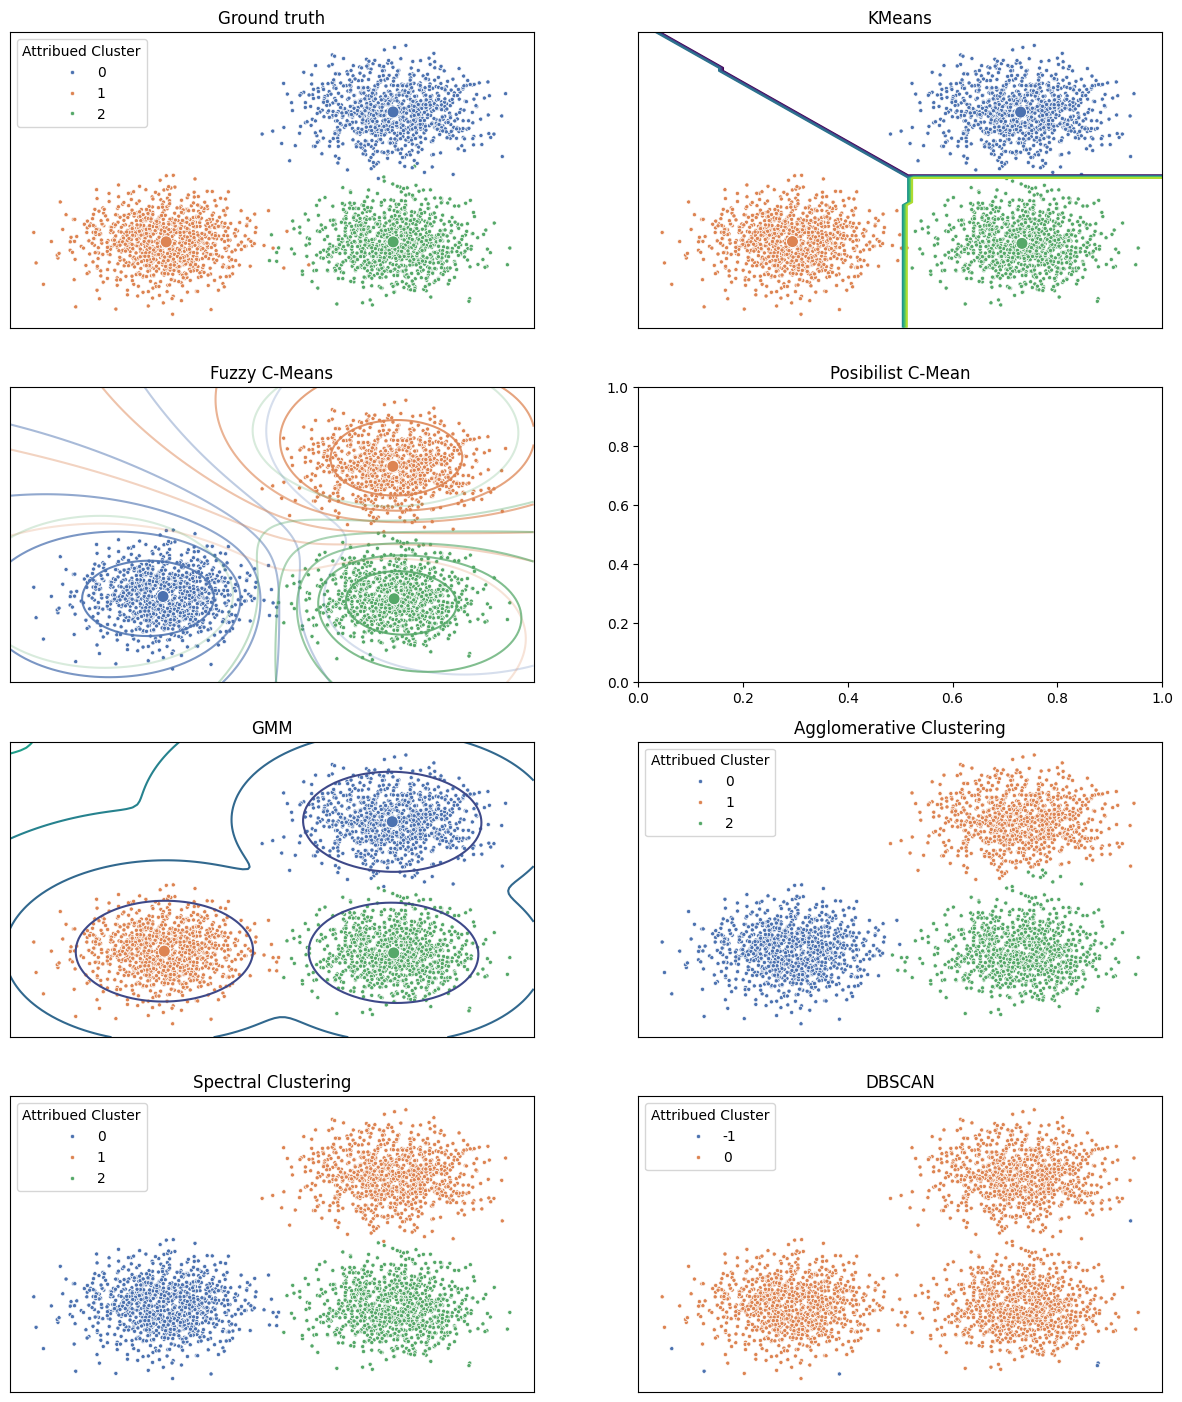

In [3]:
centers = np.array([[2, 2], [-2, -2], [2, -2]])
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=3000, centers=centers, cluster_std=0.7)
estimators, XX, X_mesh, Y_mesh  = experim(X, n_clusters, labels_true, centers)

Dans ce première exemple, on peut voir que,excepté DBSCAN, nos algorithmes arrivent à partionner notre jeu de données. 

Dans le cas de DBSCAN, il est surement nécéssaire de paufiner son hyperparamètre principal $\varepsilon$.

Les lignes de niveau de l'algorithme c-moyenne flou sont intéréssantes, regardons les de plus près.

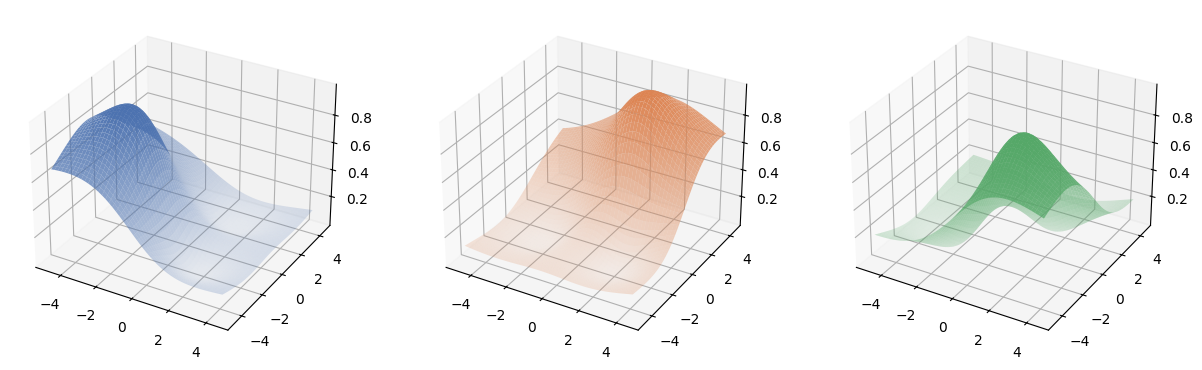

In [4]:
plot_3D(XX, X_mesh, Y_mesh, estimators['fuzzy_cmeans'], n_clusters)

({'gmm': GaussianMixture(n_components=3, random_state=0),
  'ac': AgglomerativeClustering(n_clusters=3),
  'sc': SpectralClustering(n_clusters=3),
  'dbscan': DBSCAN(),
  'fuzzy_cmeans': FuzzyCMeans(n_clusters=3),
  'k_means': KMeans(n_clusters=3, n_init='auto', random_state=0)},
 array([[-3.74816726, -3.89209357],
        [-3.67411042, -3.89209357],
        [-3.60005359, -3.89209357],
        ...,
        [ 3.43534572,  3.62321725],
        [ 3.50940256,  3.62321725],
        [ 3.58345939,  3.62321725]]),
 array([[-3.74816726, -3.67411042, -3.60005359, ...,  3.43534572,
          3.50940256,  3.58345939],
        [-3.74816726, -3.67411042, -3.60005359, ...,  3.43534572,
          3.50940256,  3.58345939],
        [-3.74816726, -3.67411042, -3.60005359, ...,  3.43534572,
          3.50940256,  3.58345939],
        ...,
        [-3.74816726, -3.67411042, -3.60005359, ...,  3.43534572,
          3.50940256,  3.58345939],
        [-3.74816726, -3.67411042, -3.60005359, ...,  3.43534572,
 

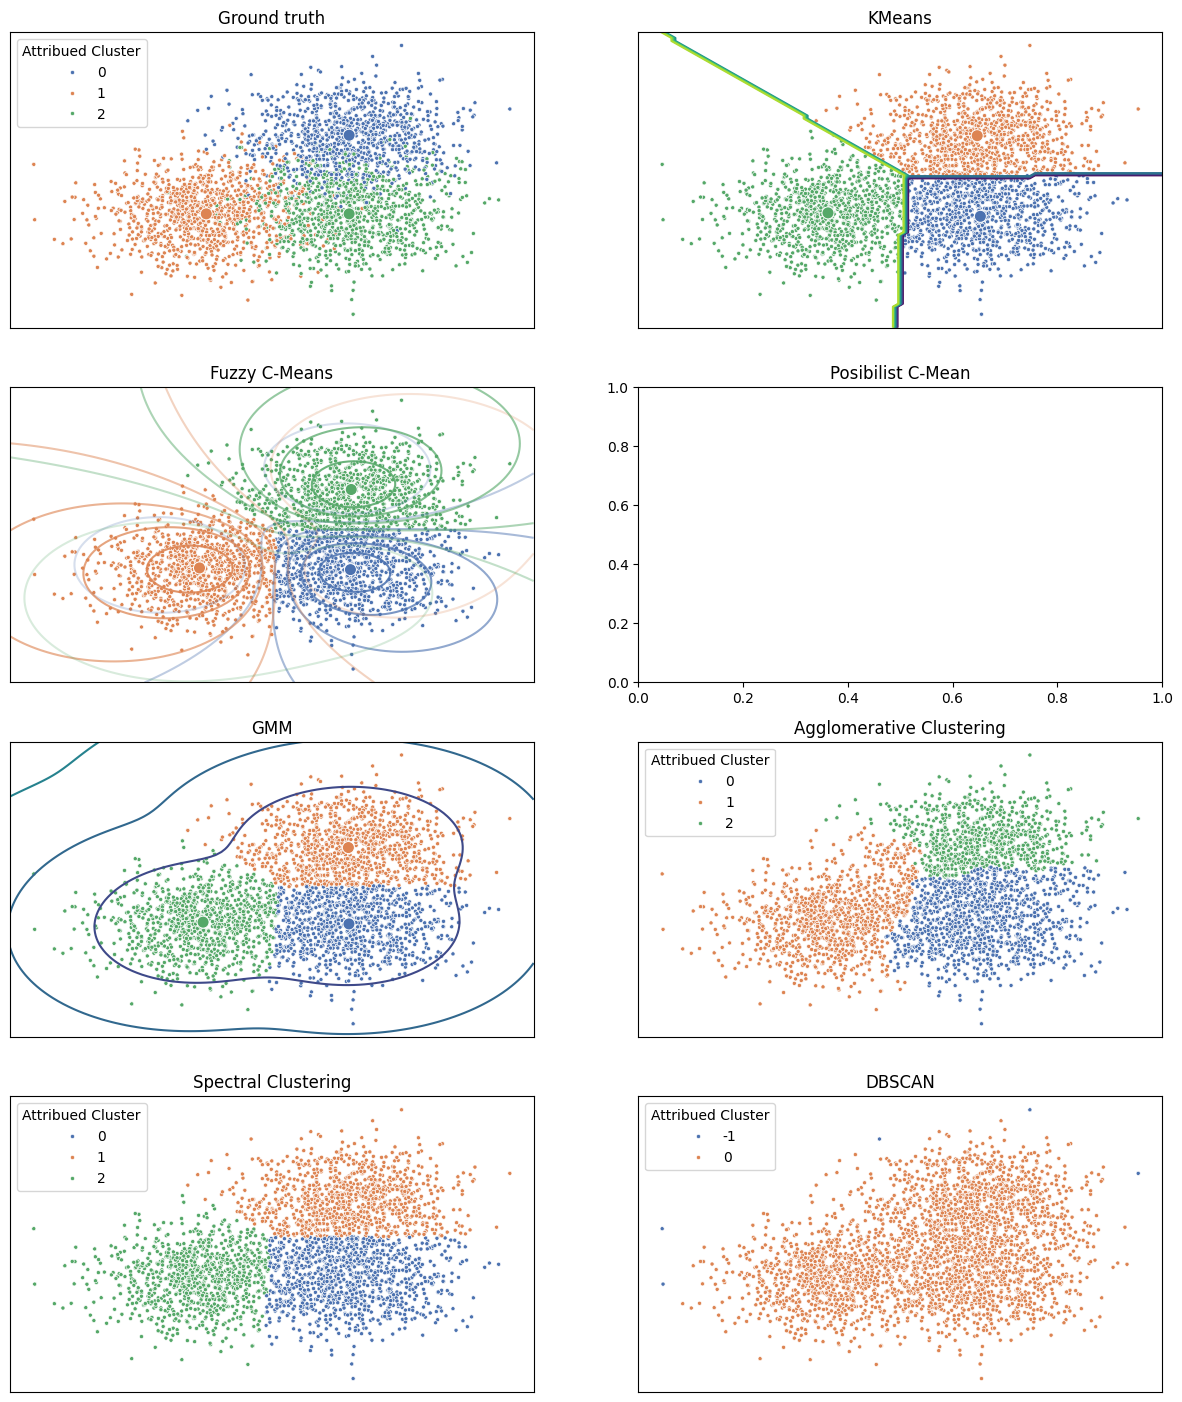

In [5]:
centers = np.array([[1, 1], [-1, -1], [1, -1]])
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=3000, centers=centers, cluster_std=0.7)
experim(X, n_clusters, labels_true, centers)

# Question 3: Comparaison des résultats sur les données `halfmoon`


({'gmm': GaussianMixture(n_components=2, random_state=0),
  'ac': AgglomerativeClustering(),
  'sc': SpectralClustering(n_clusters=2),
  'dbscan': DBSCAN(),
  'fuzzy_cmeans': FuzzyCMeans(),
  'k_means': KMeans(n_clusters=2, n_init='auto', random_state=0)},
 array([[-1.15      , -0.5749994 ],
        [-1.11666667, -0.5749994 ],
        [-1.08333333, -0.5749994 ],
        ...,
        [ 2.08333333,  1.0749994 ],
        [ 2.11666667,  1.0749994 ],
        [ 2.15      ,  1.0749994 ]]),
 array([[-1.15      , -1.11666667, -1.08333333, ...,  2.08333333,
          2.11666667,  2.15      ],
        [-1.15      , -1.11666667, -1.08333333, ...,  2.08333333,
          2.11666667,  2.15      ],
        [-1.15      , -1.11666667, -1.08333333, ...,  2.08333333,
          2.11666667,  2.15      ],
        ...,
        [-1.15      , -1.11666667, -1.08333333, ...,  2.08333333,
          2.11666667,  2.15      ],
        [-1.15      , -1.11666667, -1.08333333, ...,  2.08333333,
          2.11666667,  2.

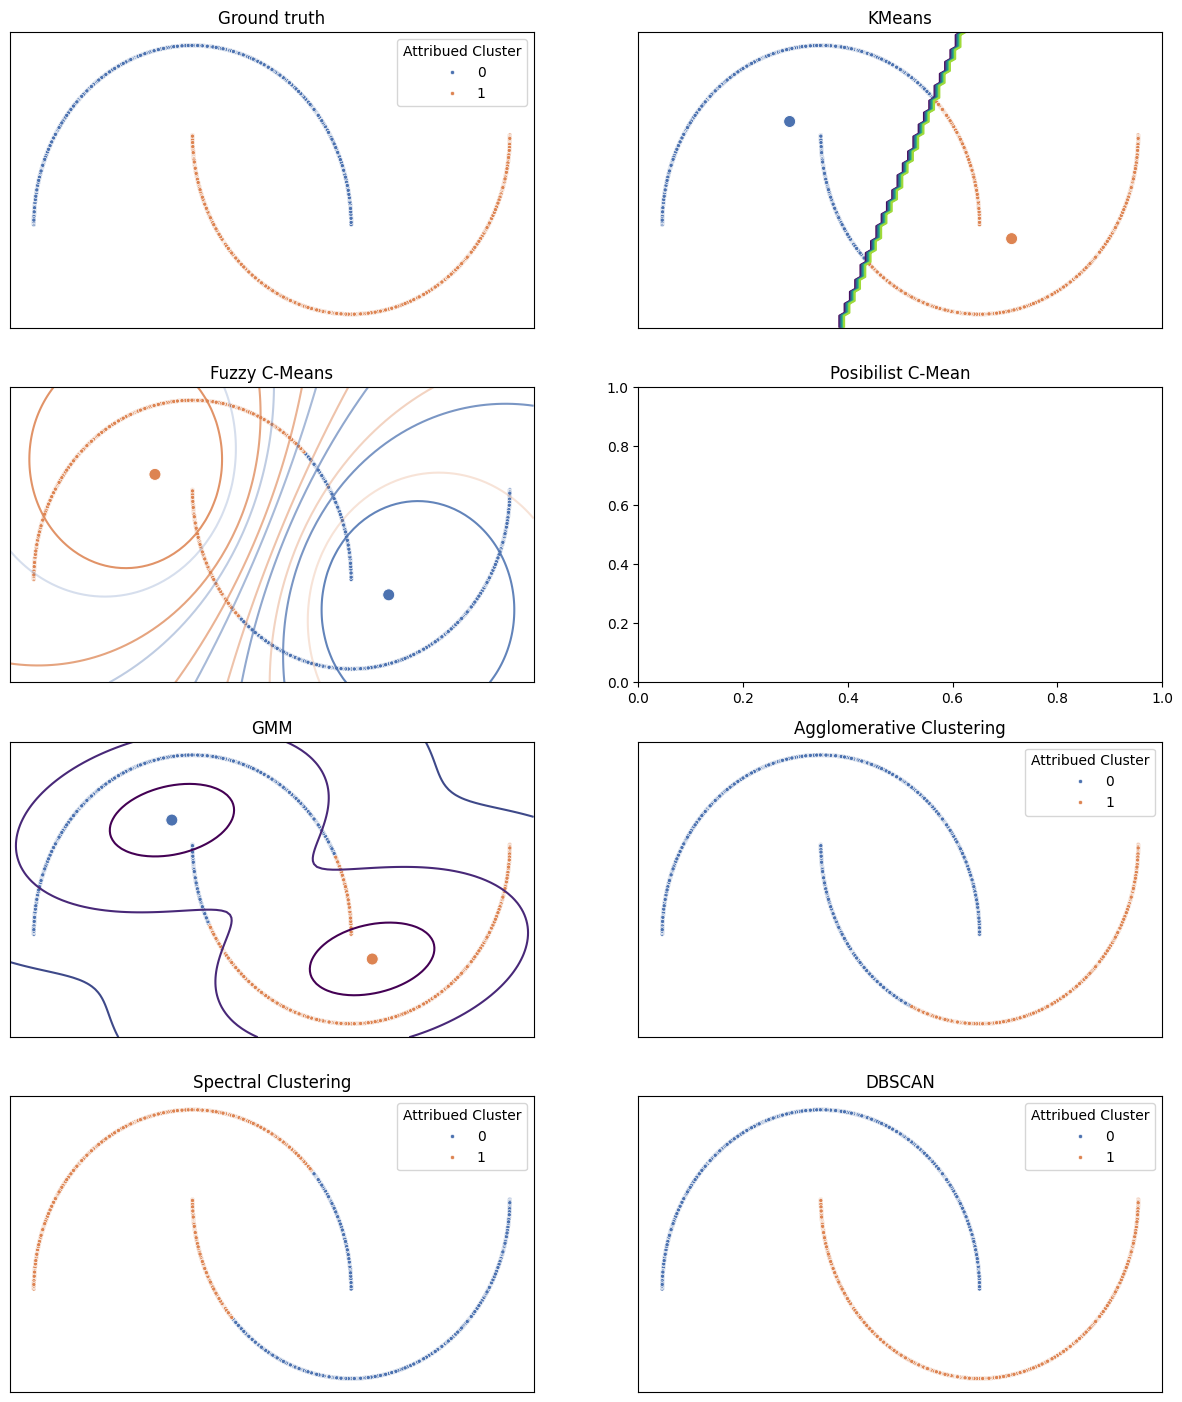

In [6]:
X, labels_true = make_moons(n_samples=3000)
experim(X, 2, labels_true)

# Question 4: Tolérance aux outliers


In [7]:
centers = [(-20, -20), (-20, 20), (20, -20), (20, 20)]
cov = [
    np.array([[1, 0], [0, 1]]),
    np.array([[1, 0], [0, 1]]),
    np.array([[1, 0], [0, 1]]),
    np.array([[1, 0], [0, 1]]),
]
n_clusters = len(centers)
X_train, X_outliers = generate_elongated(
    n_samples=300, n_clusters=4, centers=centers, cov=cov
)
obs = np.array([[0, 0]])  # le centre du plan 2D

/home/charles/M2-DAC/XAI/TME/TME9/utils.py:154: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df, x="x", y="y", palette="deep", marker=".", **kwargs)
/home/charles/M2-DAC/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


({'gmm': GaussianMixture(n_components=4, random_state=0),
  'ac': AgglomerativeClustering(n_clusters=4),
  'sc': SpectralClustering(n_clusters=4),
  'dbscan': DBSCAN(),
  'fuzzy_cmeans': FuzzyCMeans(n_clusters=4),
  'k_means': KMeans(n_clusters=4, n_init='auto', random_state=0)},
 array([[-25.55727475, -24.33383036],
        [-25.04260643, -24.33383036],
        [-24.52793812, -24.33383036],
        ...,
        [ 24.36555159,  26.14732967],
        [ 24.8802199 ,  26.14732967],
        [ 25.39488822,  26.14732967]]),
 array([[-25.55727475, -25.04260643, -24.52793812, ...,  24.36555159,
          24.8802199 ,  25.39488822],
        [-25.55727475, -25.04260643, -24.52793812, ...,  24.36555159,
          24.8802199 ,  25.39488822],
        [-25.55727475, -25.04260643, -24.52793812, ...,  24.36555159,
          24.8802199 ,  25.39488822],
        ...,
        [-25.55727475, -25.04260643, -24.52793812, ...,  24.36555159,
          24.8802199 ,  25.39488822],
        [-25.55727475, -25.0426

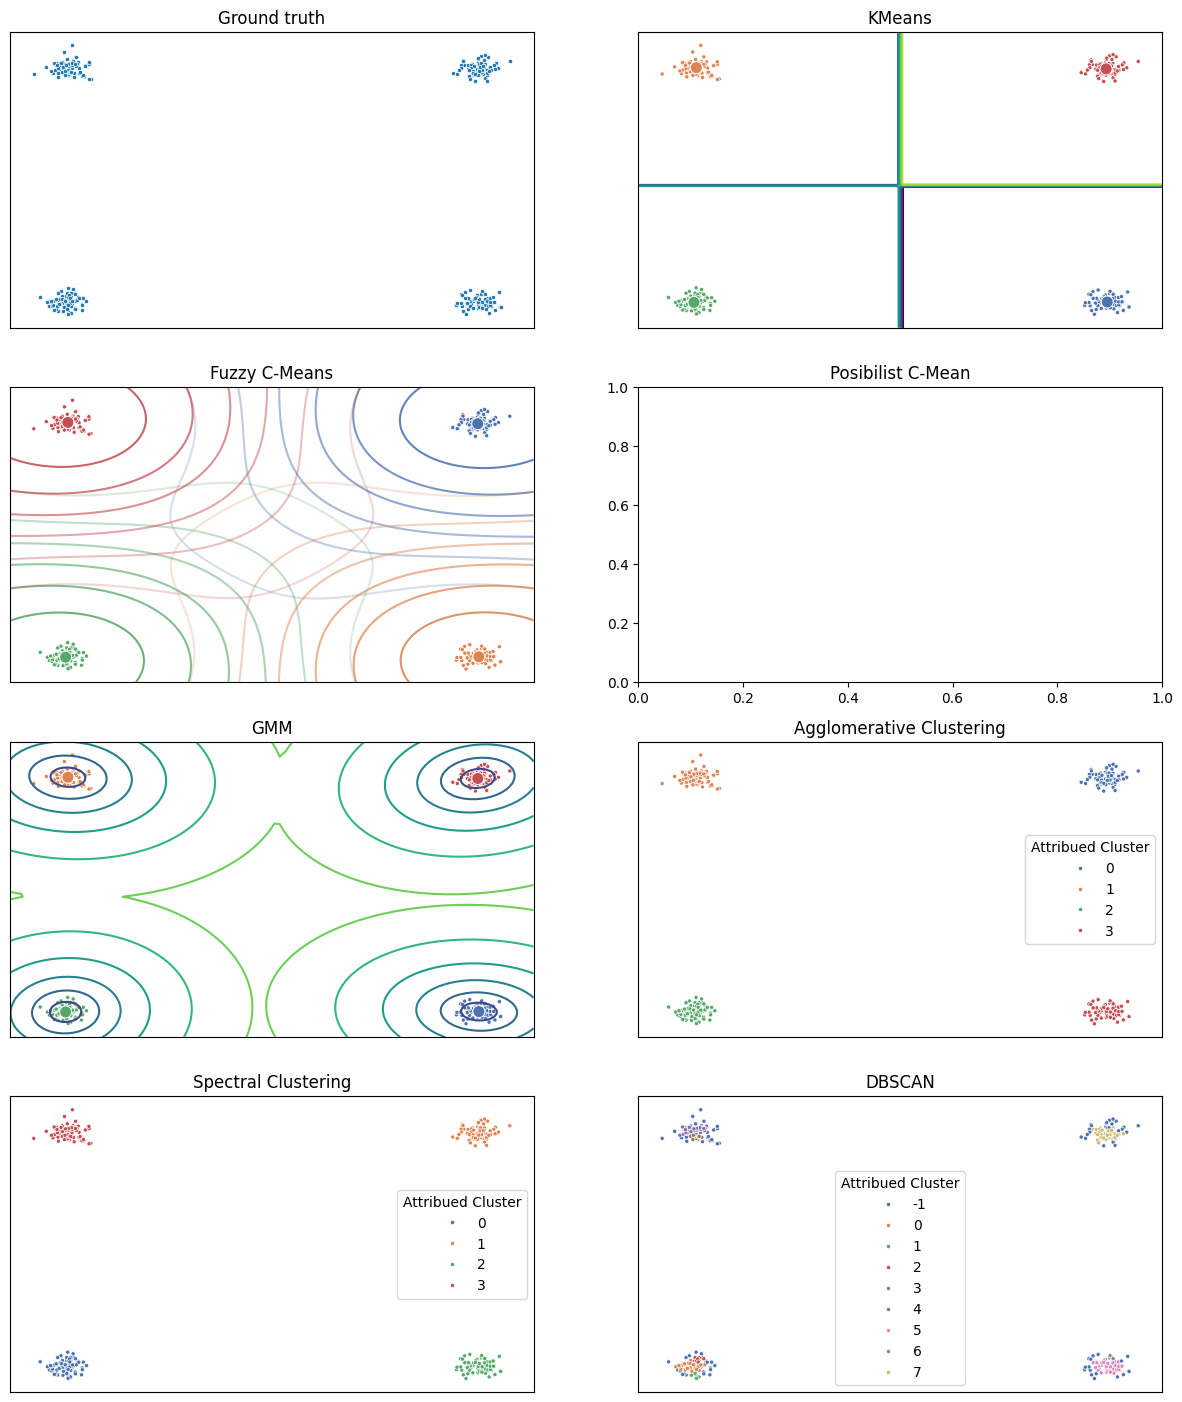

In [8]:
experim(X_train, n_clusters)

/home/charles/M2-DAC/XAI/TME/TME9/utils.py:154: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df, x="x", y="y", palette="deep", marker=".", **kwargs)
/home/charles/M2-DAC/.venv/lib/python3.11/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


({'gmm': GaussianMixture(n_components=4, random_state=0),
  'ac': AgglomerativeClustering(n_clusters=4),
  'sc': SpectralClustering(n_clusters=4),
  'dbscan': DBSCAN(),
  'fuzzy_cmeans': FuzzyCMeans(n_clusters=4),
  'k_means': KMeans(n_clusters=4, n_init='auto', random_state=0)},
 array([[-25.55727475, -24.33383036],
        [-25.04260643, -24.33383036],
        [-24.52793812, -24.33383036],
        ...,
        [ 24.36555159,  26.14732967],
        [ 24.8802199 ,  26.14732967],
        [ 25.39488822,  26.14732967]]),
 array([[-25.55727475, -25.04260643, -24.52793812, ...,  24.36555159,
          24.8802199 ,  25.39488822],
        [-25.55727475, -25.04260643, -24.52793812, ...,  24.36555159,
          24.8802199 ,  25.39488822],
        [-25.55727475, -25.04260643, -24.52793812, ...,  24.36555159,
          24.8802199 ,  25.39488822],
        ...,
        [-25.55727475, -25.04260643, -24.52793812, ...,  24.36555159,
          24.8802199 ,  25.39488822],
        [-25.55727475, -25.0426

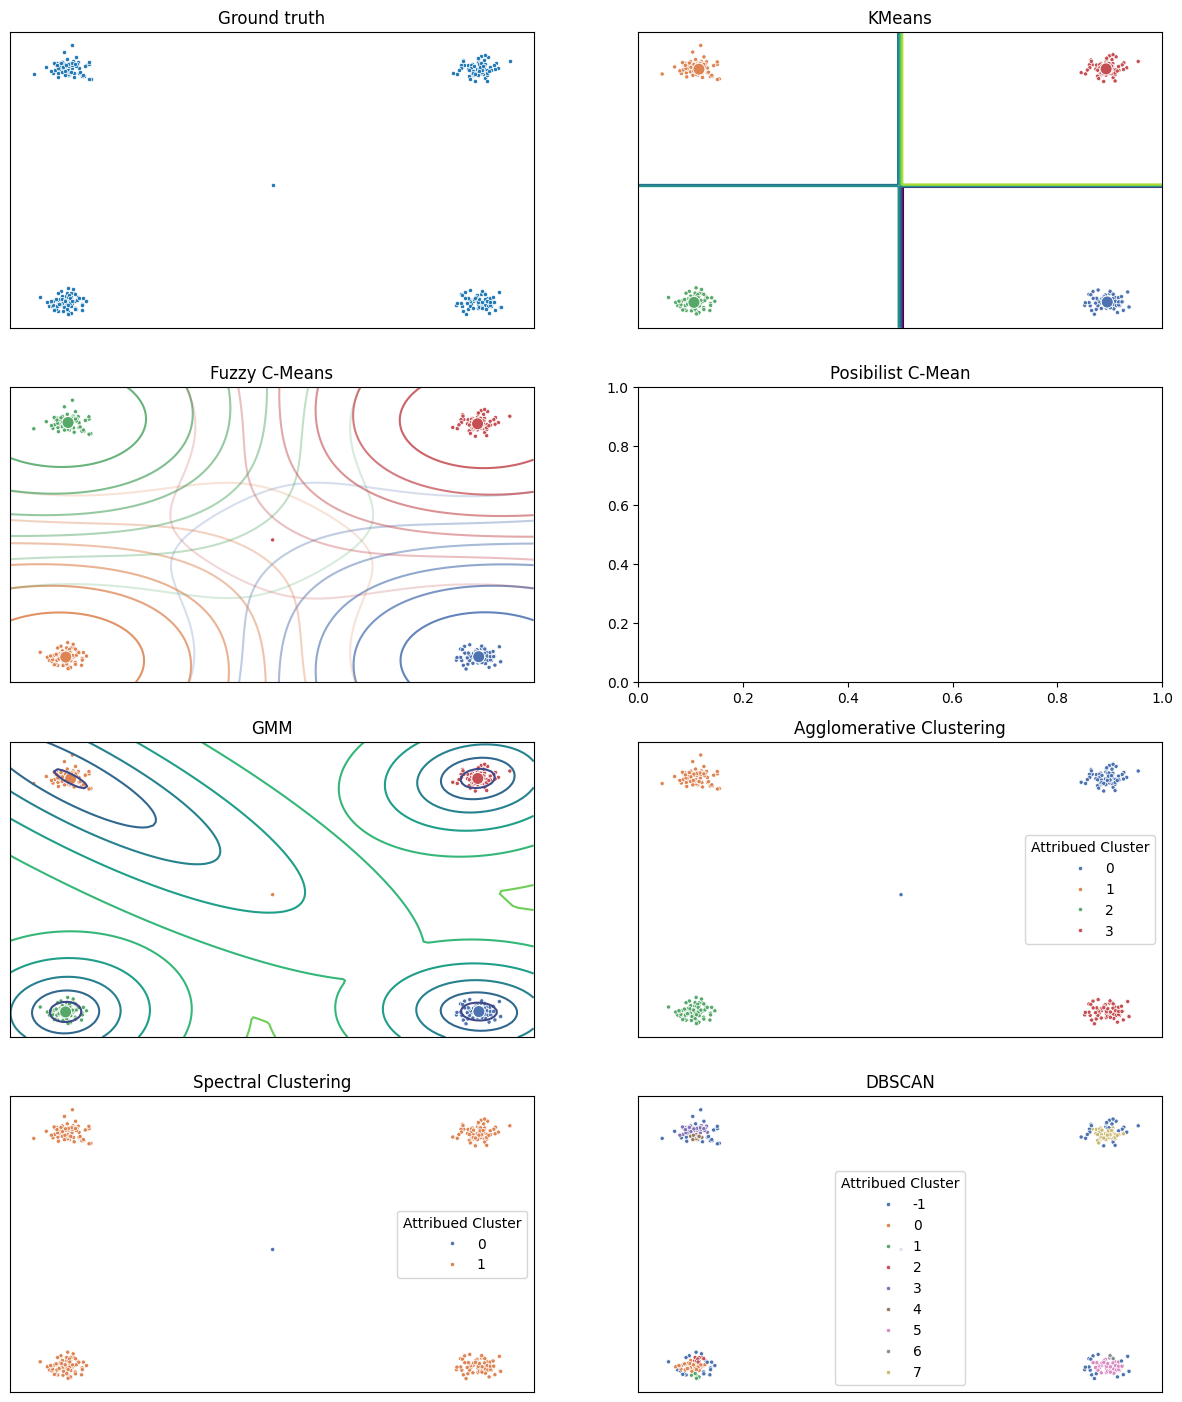

In [9]:
experim(np.concatenate((X_train, obs), 0), n_clusters)

/home/charles/M2-DAC/XAI/TME/TME9/utils.py:154: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df, x="x", y="y", palette="deep", marker=".", **kwargs)
/home/charles/M2-DAC/.venv/lib/python3.11/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


({'gmm': GaussianMixture(n_components=4, random_state=0),
  'ac': AgglomerativeClustering(n_clusters=4),
  'sc': SpectralClustering(n_clusters=4),
  'dbscan': DBSCAN(),
  'fuzzy_cmeans': FuzzyCMeans(n_clusters=4),
  'k_means': KMeans(n_clusters=4, n_init='auto', random_state=0)},
 array([[-36.07187814, -32.07688373],
        [-35.3614696 , -32.07688373],
        [-34.65106106, -32.07688373],
        ...,
        [ 32.83775016,  36.08704646],
        [ 33.5481587 ,  36.08704646],
        [ 34.25856724,  36.08704646]]),
 array([[-36.07187814, -35.3614696 , -34.65106106, ...,  32.83775016,
          33.5481587 ,  34.25856724],
        [-36.07187814, -35.3614696 , -34.65106106, ...,  32.83775016,
          33.5481587 ,  34.25856724],
        [-36.07187814, -35.3614696 , -34.65106106, ...,  32.83775016,
          33.5481587 ,  34.25856724],
        ...,
        [-36.07187814, -35.3614696 , -34.65106106, ...,  32.83775016,
          33.5481587 ,  34.25856724],
        [-36.07187814, -35.3614

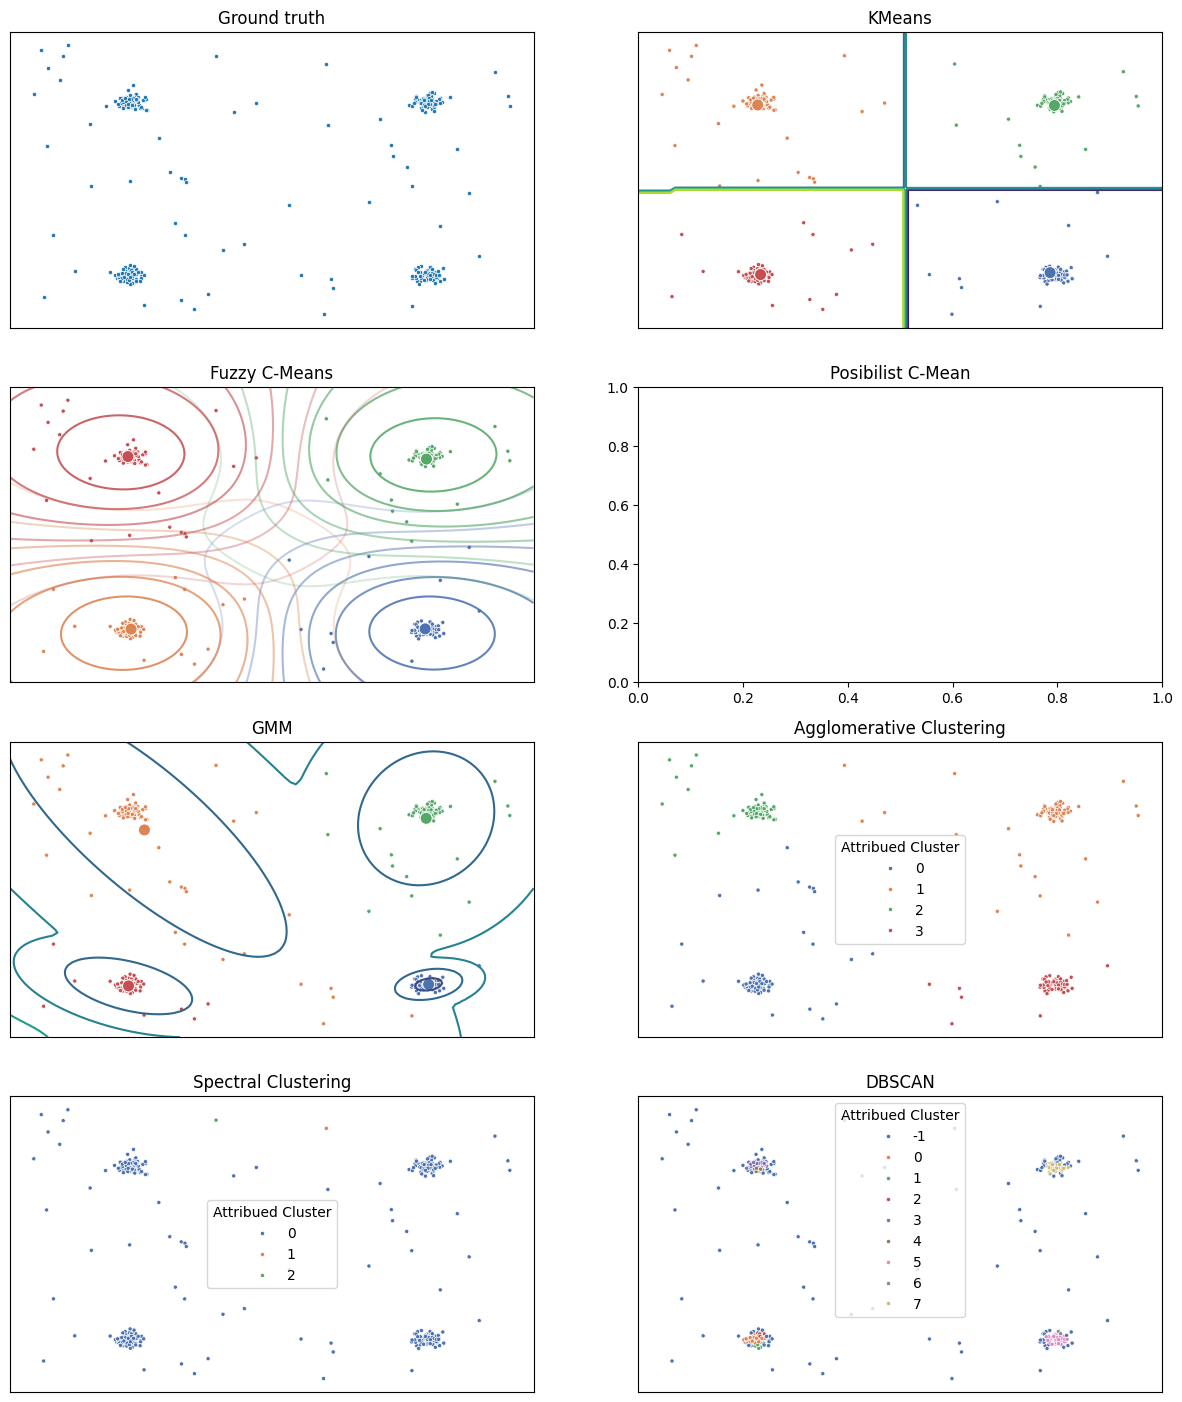

In [10]:
X = np.concatenate((X_train, X_outliers), axis=0)
experim(X, n_clusters)

# Question 5: Stabilité
